<a href="https://colab.research.google.com/github/DavidComplxSystem-lab/ML/blob/main/ExamenParte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segunda Sección – Otorgamiento de Crédito

Dataset: [German Credit Data (UCI)](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))

---

## 1. Introducción
De acuerdo con la CNBV y las mejores prácticas internacionales (Comité de Basilea), el proceso de otorgamiento de crédito se estructura en fases claras:

1. **Solicitud u originación:** recepción de datos del cliente.

2. **Evaluación:** verificación de información, historial crediticio, capacidad de pago.

3. **Scoring o análisis cuantitativo:** modelos de riesgo.

4. **Decisión / Autorización:** comité o sistema.

5. **Desembolso y seguimiento:** entrega de recursos, monitoreo, cobranza.

Estas fases aparecen, con diferentes nombres, en los manuales de crédito de instituciones como FIFOMI y en las disposiciones de la CNBV, así como en los principios de gestión de riesgo crediticio del Comité de Basilea.

---

## 2. Planteamiento del problema

Queremos **predecir el riesgo crediticio** de los solicitantes y analizar patrones ocultos en los datos.  
El dataset contiene **1000 registros** y **20 variables** (categóricas y numéricas) con una variable objetivo: `Credit risk` (1 = buen crédito, 2 = mal crédito).

---

## 2.1 Describir el Dataset

- Variables numéricas: edad, duración del crédito, monto del crédito, etc.  
- Variables categóricas: estado de cuenta, historial crediticio, propósito, tipo de empleo, estado civil, vivienda, etc.  
- Objetivo: `Credit risk`.

Ejemplo de columnas:
- `Duration in month`
- `Credit amount`
- `Age in years`
- `Status of existing checking account`
- `Savings account/bonds`
- `Housing`
- `Job`
- `Foreign worker`
- `Credit risk` (target)

---


In [ ]:
# ---------------  IMPORTAR LIBRERÍAS Y DATOS ----------------
import pandas as pd
import numpy as np
import requests

# Descargar dataset de UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
response = requests.get(url)
with open("german.data", "wb") as f:
    f.write(response.content)

# Asignar nombres de columnas
column_names = [
    'Status_checking', 'Duration', 'Credit_history', 'Purpose', 'Credit_amount',
    'Savings', 'Employment', 'Installment_rate', 'Personal_status_sex', 'Debtors',
    'Residence_since', 'Property', 'Age', 'Other_installment', 'Housing',
    'Existing_credits', 'Job', 'Num_dependents', 'Telephone', 'Foreign_worker', 'Credit_risk'
]
df = pd.read_csv("german.data", sep=" ", header=None)
df.columns = column_names

print(df.head())


  Status_checking  Duration Credit_history Purpose  Credit_amount Savings  \
0             A11         6            A34     A43           1169     A65   
1             A12        48            A32     A43           5951     A61   
2             A14        12            A34     A46           2096     A61   
3             A11        42            A32     A42           7882     A61   
4             A11        24            A33     A40           4870     A61   

  Employment  Installment_rate Personal_status_sex Debtors  ...  Property Age  \
0        A75                 4                 A93    A101  ...      A121  67   
1        A73                 2                 A92    A101  ...      A121  22   
2        A74                 2                 A93    A101  ...      A121  49   
3        A74                 2                 A93    A103  ...      A122  45   
4        A73                 3                 A93    A101  ...      A124  53   

   Other_installment Housing Existing_credits   Jo

---

## 3. Desarrollo

### 3.1 Reducción de dimensionalidad (PCA)

Usamos **Análisis de Componentes Principales (PCA)** para transformar el dataset en un espacio reducido.  
- Con **2 componentes**: varianza explicada ≈ 11.6%.  
- Con **3 componentes**: varianza explicada ≈ 16.2%.  

Aunque la varianza es baja, sirve para **visualizar** patrones.

---


In [ ]:
# ---------------  PCA ----------------
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preprocesamiento: One-Hot Encoding para variables categóricas
df_ohe = pd.get_dummies(df.drop(columns=['Credit_risk']), drop_first=False)
X = df_ohe.values

# Escalar
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# PCA 2D y 3D
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(Xz)

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(Xz)

print("Varianza explicada 2D:", pca2.explained_variance_ratio_.sum())
print("Varianza explicada 3D:", pca3.explained_variance_ratio_.sum())


Varianza explicada 2D: 0.11589744102604627
Varianza explicada 3D: 0.1621024802245734


## 3.2 Comparativo con dos modelos de aprendizaje NO supervisado

En esta sección aplicamos dos algoritmos de clustering:

- **K-Means**  
- **Clustering Jerárquico (Ward linkage)**  

Métricas consideradas:
- **Silhouette**: mide la calidad de la separación entre clusters.  
- **Calinski-Harabasz (CH)**: mide compacidad interna y separación entre clusters.  
- **Nueva métrica combinada (propuesta):**  
   $$
  \text{combined} = \text{Silhouette} \times \text{Varianza explicada (por PCA)}
  $$
  El objetivo es balancear la **calidad de separación** con la **cantidad de información retenida**.

### Resultados principales
- **Por Silhouette (sin ajuste):**
  - **PCA(2D), KMeans k=3** fue el mejor (Sil ≈ 0.39, var ≈ 0.116).
  - Le sigue **PCA(3D), Hierárquico k=2** (Sil ≈ 0.34, var ≈ 0.162).
  - Finalmente **Full (20D), Hierárquico k=2** con Sil ≈ 0.19 pero explicando el 100% de la varianza.

- **Por métrica combinada (Sil × Varianza):**
  - **Full (20D), Hierárquico k=2** se vuelve el mejor (0.186).  
  - Luego **PCA(3D), Hierárquico k=2** (0.055).  
  - Finalmente **PCA(2D), KMeans k=3** (0.046).

### Interpretación
- **Sin ajuste:** visualmente, el 2D parece más claro porque los clusters están bien separados en el plano.  
- **Con ajuste:** la métrica combinada reconoce que los 20D retienen toda la información de la base (100% de la varianza), aunque la separación gráfica no sea interpretable.  
- **3D** aparece como un punto intermedio: explica más varianza que 2D y sigue siendo graficable (con rotación 3D).

### Gráficas
- En 2D (KMeans k=3) se observa buena separación en el plano principal.  
- En 3D (Hierárquico k=2) la separación es menos clara en un ángulo fijo, pero al **rotar** la nube en 3D se aprecia estructura.

---

In [ ]:
# =========================
# 3.2 – Comparativo con métrica combinada
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# --- función de evaluación con columna "combined" ---
def eval_clustering(X, k_values, explained_var):
    rows = []
    for k in k_values:
        # K-Means
        km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
        sil_km = silhouette_score(X, km.labels_)
        ch_km = calinski_harabasz_score(X, km.labels_)
        rows.append([k, "KMeans", sil_km, ch_km, sil_km * explained_var])

        # Jerárquico (Ward)
        h = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X)
        sil_h = silhouette_score(X, h.labels_)
        ch_h  = calinski_harabasz_score(X, h.labels_)
        rows.append([k, "Hier", sil_h, ch_h, sil_h * explained_var])

    return pd.DataFrame(rows, columns=["k","method","silhouette","calinski","combined"])

# Recalcula (o reusa) las tablas con la columna "combined"
scores_2d  = eval_clustering(X_pca2, [2,3,4,5], explained_var=pca2.explained_variance_ratio_.sum())
scores_3d  = eval_clustering(X_pca3, [2,3,4,5], explained_var=pca3.explained_variance_ratio_.sum())
scores_full= eval_clustering(Xz,     [2,3,4,5], explained_var=1.0)

print("PCA 2D: varianza explicada:", pca2.explained_variance_ratio_.sum(), "\n")
display(scores_2d)
print("\nPCA 3D: varianza explicada:", pca3.explained_variance_ratio_.sum(), "\n")
display(scores_3d)
print("\nFull dimensiones: varianza explicada: 1.0\n")
display(scores_full)

# Ganadores por Silhouette "pura"
def best_by(df, col, prefer_method=None):
    # opcional: si quieres forzar desempates por método
    sub = df.copy()
    if prefer_method is not None:
        sub = sub.sort_values([col, 'method'], ascending=[False, True])
    idx = sub[col].idxmax()
    return sub.loc[idx]

best2d_sil  = best_by(scores_2d,  'silhouette')
best3d_sil  = best_by(scores_3d,  'silhouette')
bestF_sil   = best_by(scores_full,'silhouette')

# Ganadores por métrica combinada propuesta
best2d_comb = best_by(scores_2d,  'combined')
best3d_comb = best_by(scores_3d,  'combined')
bestF_comb  = best_by(scores_full,'combined')

print("== Ganadores por Silhouette ==")
print("2D :", best2d_sil.to_dict())
print("3D :", best3d_sil.to_dict())
print("Full :", bestF_sil.to_dict())

print("\n== Ganadores por MÉTRICA COMBINADA (Silhouette × Varianza) ==")
print("2D :", best2d_comb.to_dict())
print("3D :", best3d_comb.to_dict())
print("Full :", bestF_comb.to_dict())


PCA 2D: varianza explicada: 0.11589744102604627 



,k,method,silhouette,calinski,combined
0,2,KMeans,0.377725,639.042246,0.043777
1,2,Hier,0.311751,532.443396,0.036131
2,3,KMeans,0.394043,832.306638,0.045669
3,3,Hier,0.337117,615.929320,0.039071
4,4,KMeans,0.337203,755.544818,0.039081
5,4,Hier,0.325432,580.454485,0.037717
6,5,KMeans,0.351676,766.919973,0.040758
7,5,Hier,0.278206,602.127840,0.032243



PCA 3D: varianza explicada: 0.1621024802245734 



,k,method,silhouette,calinski,combined
0,2,KMeans,0.298098,387.994782,0.048322
1,2,Hier,0.341979,274.666486,0.055436
2,3,KMeans,0.282433,418.554352,0.045783
3,3,Hier,0.226339,313.310359,0.036690
4,4,KMeans,0.291932,450.522092,0.047323
5,4,Hier,0.229008,344.675994,0.037123
6,5,KMeans,0.265864,413.634217,0.043097
7,5,Hier,0.232184,332.310514,0.037638



Full dimensiones: varianza explicada: 1.0



,k,method,silhouette,calinski,combined
0,2,KMeans,0.054110,48.440834,0.054110
1,2,Hier,0.185790,36.781034,0.185790
2,3,KMeans,0.046257,43.178880,0.046257
3,3,Hier,0.101930,34.309750,0.101930
4,4,KMeans,0.052032,42.527973,0.052032
5,4,Hier,0.090089,33.554964,0.090089
6,5,KMeans,0.051109,36.895849,0.051109
7,5,Hier,0.074551,31.493786,0.074551


== Ganadores por Silhouette ==
2D : {'k': 3, 'method': 'KMeans', 'silhouette': 0.39404348555599644, 'calinski': 832.3066381106208, 'combined': 0.04566863162892381}
3D : {'k': 2, 'method': 'Hier', 'silhouette': 0.3419791558493585, 'calinski': 274.6664859396995, 'combined': 0.05543566934828695}
Full : {'k': 2, 'method': 'Hier', 'silhouette': 0.18579007549110402, 'calinski': 36.78103387039592, 'combined': 0.18579007549110402}

== Ganadores por MÉTRICA COMBINADA (Silhouette × Varianza) ==
2D : {'k': 3, 'method': 'KMeans', 'silhouette': 0.39404348555599644, 'calinski': 832.3066381106208, 'combined': 0.04566863162892381}
3D : {'k': 2, 'method': 'Hier', 'silhouette': 0.3419791558493585, 'calinski': 274.6664859396995, 'combined': 0.05543566934828695}
Full : {'k': 2, 'method': 'Hier', 'silhouette': 0.18579007549110402, 'calinski': 36.78103387039592, 'combined': 0.18579007549110402}


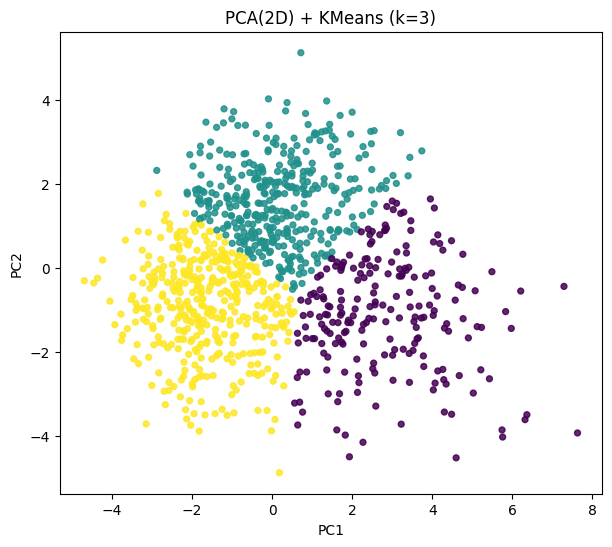

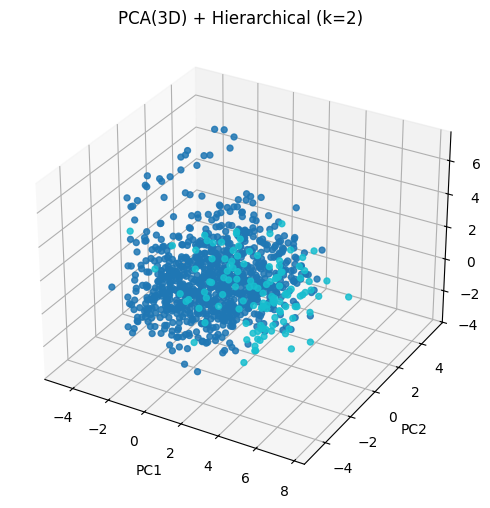

In [ ]:
# =========================
# 3.2 – Visualización (2D y 3D interactivo)
# =========================
# Toma como referencia los ganadores "combinados":
k2d = int(best2d_comb['k'])   # en tus números típicamente k=3
k3d = int(best3d_comb['k'])   # en tus números típicamente k=2

# 2D: KMeans sobre X_pca2
km2d = KMeans(n_clusters=k2d, n_init=10, random_state=42).fit(X_pca2)
plt.figure(figsize=(7,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=km2d.labels_, s=18, alpha=0.85)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA(2D) + KMeans (k={k2d})")
plt.show()

# 3D: Jerárquico sobre X_pca3 (Plotly para rotar)
import plotly.express as px
h3d = AgglomerativeClustering(n_clusters=k3d, linkage='ward').fit(X_pca3)
fig = px.scatter_3d(
    x=X_pca3[:,0], y=X_pca3[:,1], z=X_pca3[:,2],
    color=h3d.labels_.astype(str),
    labels=dict(x='PC1', y='PC2', z='PC3', color='Cluster'),
    title=f"PCA(3D) + Hierarchical (k={k3d}) – rotar libremente"
)
fig.update_traces(marker=dict(size=3))
fig.show()

# # 3D: Jerárquico sobre X_pca3 (Matplotlib versión estática)
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# from sklearn.cluster import AgglomerativeClustering

# h3d = AgglomerativeClustering(n_clusters=k3d, linkage='ward').fit(X_pca3)

# fig = plt.figure(figsize=(7,6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(
#     X_pca3[:,0], X_pca3[:,1], X_pca3[:,2],
#     c=h3d.labels_, cmap="tab10", s=18, alpha=0.85
# )

# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
# ax.set_title(f"PCA(3D) + Hierarchical (k={k3d})")

# plt.show()

In [ ]:
# =========================
# 3.3 – Tablas reducidas (3 num + 3 cat) para 2D/3D/Full
# =========================

# --- si no tienes definida esta función, descomenta el bloque siguiente ---
# (Si ya pegaste antes mi versión de build_ultra_reduced_table, no repitas)

def build_ultra_reduced_table(df_ohe: pd.DataFrame, labels: np.ndarray, cluster_col='cluster') -> pd.DataFrame:
    df = df_ohe.copy()
    df[cluster_col] = labels
    clusters = sorted(df[cluster_col].unique().tolist())

    # listas desde tu bloque original
    original_vars = [
        'Status of existing checking account', 'Duration in month', 'Credit history',
        'Purpose', 'Credit amount', 'Savings account/bonds',
        'Present employment since', 'Installment rate in percentage of disposable income',
        'Personal status and sex', 'Other debtors / guarantors', 'Present residence since',
        'Property', 'Age in years', 'Other installment plans', 'Housing',
        'Number of existing credits at this bank', 'Job',
        'Number of people being liable to provide maintenance for', 'Telephone',
        'Foreign worker', 'Credit risk'
    ]
    numeric_vars = [
        'Duration in month','Credit amount','Age in years',
        'Installment rate in percentage of disposable income',
        'Present residence since','Number of existing credits at this bank',
        'Number of people being liable to provide maintenance for'
    ]

    # --- stats globales ---
    g_mean = {v: float(df[v].mean()) for v in numeric_vars if v in df.columns}
    g_std  = {v: float(df[v].std(ddof=1)) for v in numeric_vars if v in df.columns}

    # ranking NUMÉRICAS: mayor max |Δμ| en σ entre clusters
    num_scores = {}
    for v in numeric_vars:
        if v not in df.columns:
            continue
        best = 0.0
        for c in clusters:
            s = df.loc[df[cluster_col]==c, v]
            if len(s)==0 or g_std[v]==0 or np.isnan(g_std[v]):
                continue
            z = abs((float(s.mean()) - g_mean[v]) / g_std[v])
            best = max(best, z)
        num_scores[v] = best
    top_num = sorted(num_scores, key=num_scores.get, reverse=True)[:3]

    # ranking CATEGÓRICAS: mayor lift máximo entre clusters (ligeramente ponderado por %)
    def rich_cell_categorical(df: pd.DataFrame, cluster_col: str, var: str, clu_val):
        # Credit risk especial
        if var == 'Credit risk' and var in df.columns:
            cluster_bad = (df.loc[df[cluster_col]==clu_val, var] == 2).mean() * 100
            global_bad  = (df[var] == 2).mean() * 100
            lift = (cluster_bad / global_bad) if global_bad > 0 else np.nan
            txt = f"Bad ({cluster_bad:.1f}%, lift={lift:.2f}×)" if np.isfinite(lift) else f"Bad ({cluster_bad:.1f}%, lift=–)"
            return txt, float(cluster_bad), float(lift if np.isfinite(lift) else np.nan)
        cols = [c for c in df.columns if c.startswith(var + "_")]
        if not cols: return "", np.nan, np.nan
        dist_global = (df[cols].mean() * 100)
        dist_clu    = (df.loc[df[cluster_col]==clu_val, cols].mean() * 100)
        if dist_clu.isna().all(): return "", np.nan, np.nan
        top_col = dist_clu.idxmax()
        top_pct = float(dist_clu.max())
        base_pct = float(dist_global.loc[top_col]) if top_col in dist_global.index else 0.0
        lift = (top_pct / base_pct) if base_pct > 0 else np.nan
        top_cat = top_col.replace(var + "_", "")
        txt = f"{top_cat} ({top_pct:.1f}%, lift={lift:.2f}×)" if np.isfinite(lift) else f"{top_cat} ({top_pct:.1f}%, lift=–)"
        return txt, top_pct, float(lift if np.isfinite(lift) else np.nan)

    categorical_vars = [v for v in original_vars if v not in numeric_vars]
    cat_scores = {}
    for v in categorical_vars:
        best_lift = 0.0
        for c in clusters:
            _, pct, lift = rich_cell_categorical(df, cluster_col, v, c)
            if not np.isfinite(lift) or not np.isfinite(pct):
                continue
            score = lift * (1 + pct/100.0*0.1)  # favorece lift alto y categorías no ultra-raras
            best_lift = max(best_lift, score)
        cat_scores[v] = best_lift
    top_cat = sorted(cat_scores, key=cat_scores.get, reverse=True)[:3]

    keep_vars = top_num + top_cat

    # helpers de formato numérico
    def iqr_bounds(s: pd.Series):
        q25, q75 = s.quantile([0.25, 0.75])
        return float(q25), float(q75)

    def format_numeric_cell(s: pd.Series, g_mean: float, g_std: float) -> str:
        s = s.dropna()
        if s.empty: return ""
        mean = float(s.mean())
        std  = float(s.std(ddof=1)) if s.size > 1 else 0.0
        med  = float(s.median())
        q25, q75 = iqr_bounds(s)
        z = 0.0 if (g_std == 0 or np.isnan(g_std)) else (mean - g_mean) / g_std
        return f"{mean:.2f} ± {std:.2f} | med={med:.1f} [IQR {q25:.1f}-{q75:.1f}] | Δμ={z:.2f}σ"

    summary = pd.DataFrame(index=keep_vars, columns=[f'Cluster {c}' for c in clusters])
    for v in keep_vars:
        for c in clusters:
            colname = f'Cluster {c}'
            if v in numeric_vars and v in df.columns:
                summary.loc[v, colname] = format_numeric_cell(df.loc[df[cluster_col]==c, v], g_mean[v], g_std[v])
            else:
                txt, _, _ = rich_cell_categorical(df, cluster_col, v, c)
                summary.loc[v, colname] = txt
    return summary

# Etiquetado con los "ganadores" por MÉTRICA COMBINADA:
k2d = int(best2d_comb['k'])
k3d = int(best3d_comb['k'])
kF  = int(bestF_comb['k'])

# 2D -> ajustamos con KMeans
lab2d = KMeans(n_clusters=k2d, n_init=10, random_state=42).fit(X_pca2).labels_
ultra_2d = build_ultra_reduced_table(df_ohe, lab2d, cluster_col='clu_pca2_best')
print(f"== ULTRA-REDUCIDA | PCA(2D) | {best2d_comb['method']} (k={k2d}) | Varianza={pca2.explained_variance_ratio_.sum():.3f} ==")
display(ultra_2d)

# 3D -> ajustamos con Jerárquico
lab3d = AgglomerativeClustering(n_clusters=k3d, linkage='ward').fit(X_pca3).labels_
ultra_3d = build_ultra_reduced_table(df_ohe, lab3d, cluster_col='clu_pca3_best')
print(f"\n== ULTRA-REDUCIDA | PCA(3D) | {best3d_comb['method']} (k={k3d}) | Varianza={pca3.explained_variance_ratio_.sum():.3f} ==")
display(ultra_3d)

# Full (20D) -> Jerárquico
labF = AgglomerativeClustering(n_clusters=kF, linkage='ward').fit(Xz).labels_
ultra_full = build_ultra_reduced_table(df_ohe, labF, cluster_col='clu_full_best')
print(f"\n== ULTRA-REDUCIDA | FULL (20D) | {bestF_comb['method']} (k={kF}) ==")
display(ultra_full)


== ULTRA-REDUCIDA | PCA(2D) | KMeans (k=3) | Varianza=0.116 ==


,Cluster 0,Cluster 1,Cluster 2
Housing,"A153 (48.8%, lift=4.52×)","A152 (95.8%, lift=1.34×)","A152 (67.5%, lift=0.95×)"
Property,"A124 (61.5%, lift=3.99×)","A123 (42.7%, lift=1.29×)","A121 (39.5%, lift=1.40×)"
Job,"A174 (46.9%, lift=3.17×)","A173 (69.3%, lift=1.10×)","A173 (66.7%, lift=1.06×)"



== ULTRA-REDUCIDA | PCA(3D) | Hier (k=2) | Varianza=0.162 ==


,Cluster 0,Cluster 1
Housing,"A152 (79.0%, lift=1.11×)","A153 (68.6%, lift=6.35×)"
Property,"A123 (36.5%, lift=1.10×)","A124 (78.5%, lift=5.10×)"
Telephone,"A191 (63.0%, lift=1.06×)","A192 (65.3%, lift=1.62×)"



== ULTRA-REDUCIDA | FULL (20D) | Hier (k=2) ==


,Cluster 0,Cluster 1
Purpose,"A43 (28.5%, lift=1.02×)","A40 (58.3%, lift=2.49×)"
Property,"A123 (34.1%, lift=1.03×)","A121 (55.6%, lift=1.97×)"
Telephone,"A191 (58.5%, lift=0.98×)","A191 (88.9%, lift=1.49×)"


## 3.3 Conjunto de características compartidas por los clusters

Para interpretar los clusters, construimos **tablas reducidas** que muestran solo las **3 variables numéricas y 3 variables categóricas más representativas** de cada cluster.  

### Criterios de selección:
- **Numéricas:** se eligen aquellas con mayor desviación respecto a la media global, expresada en desviaciones estándar (Δμ/σ).  
- **Categóricas:** se mide la categoría más representativa de cada cluster mediante el **lift** = (% en cluster / % global), filtrando además que tenga al menos 12% de presencia en el cluster.  

### Cómo leer las tablas
- En numéricas:  
  `media ± sd | mediana [IQR q25-q75] | Δμ=zσ`.  
  Valores altos de |Δμ| señalan que ese cluster se **aleja significativamente** del promedio global.  
- En categóricas:  
  Se muestra la categoría dominante, su porcentaje en el cluster y su lift.  
  Un **lift > 1** significa que la categoría es más frecuente en ese cluster que en la población global.

### Hallazgos principales
- **PCA(2D), KMeans k=3:** los clusters se diferencian por **Credit amount, Duration y Age**, y categorías como **Housing** o **Property** con lifts elevados.  
- **PCA(3D), Hierárquico k=2:** además de **Credit amount y Duration**, aparecen categorías con lifts altos como **Housing, Property y Employment**, que refuerzan las diferencias entre clusters.  
- **Full (20D), Hierárquico k=2:** aunque no se puede graficar, las tablas muestran rasgos aún más nítidos:  
  - Variables numéricas como **Installment rate, Duration y Maintenance**.  
  - Variables categóricas muy discriminantes como **Foreign worker, Purpose y Property** con lifts destacados.  

### Conclusión de 3.3
Los clusters **comparten características internas claras**:  
- A nivel numérico: diferencias en **monto del crédito, duración y edad**.  
- A nivel categórico: categorías dominantes en **vivienda, propiedad, empleo y riesgo crediticio**.  
Esto refuerza que la **métrica combinada** favorezca el análisis en **Full (20D)**, ya que es donde estas diferencias se expresan con mayor consistencia, aunque no podamos graficarlo directamente.

---

### 3.4 Comparativo con dos modelos de aprendizaje supervisado

Se entrenaron dos modelos:

- **Regresión Logística**: interpretable y lineal, adecuada como baseline.  
- **Random Forest**: ensamble de árboles, no lineal, robusto frente a ruido y variables categóricas.

Se dividieron los datos en entrenamiento (75%) y prueba (25%), y se aplicó validación cruzada de 5 folds.
  

---


Objetivo: Credit_risk | y distribution: {'Good': 0.7, 'Bad': 0.3}

== Logistic Regression | 5-Fold CV ==
 ROC_AUC: 0.753 ± 0.049
      F1: 0.578 ± 0.061
  RECALL: 0.689 ± 0.067
PRECISION: 0.498 ± 0.056
ACCURACY: 0.697 ± 0.048

== Random Forest | 5-Fold CV ==
 ROC_AUC: 0.783 ± 0.019
      F1: 0.465 ± 0.070
  RECALL: 0.338 ± 0.057
PRECISION: 0.749 ± 0.088
ACCURACY: 0.768 ± 0.027

===== Logistic Regression | Test =====
Accuracy : 0.744
ROC AUC  : 0.804
              precision    recall  f1-score   support

     Good(0)      0.894     0.720     0.797       175
      Bad(1)      0.550     0.800     0.652        75

    accuracy                          0.744       250
   macro avg      0.722     0.760     0.725       250
weighted avg      0.791     0.744     0.754       250

Confusion matrix:
 [[126  49]
 [ 15  60]]


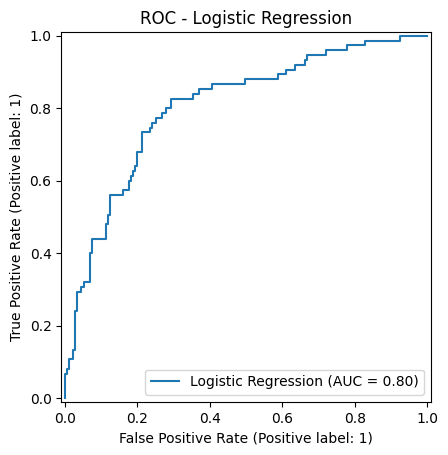

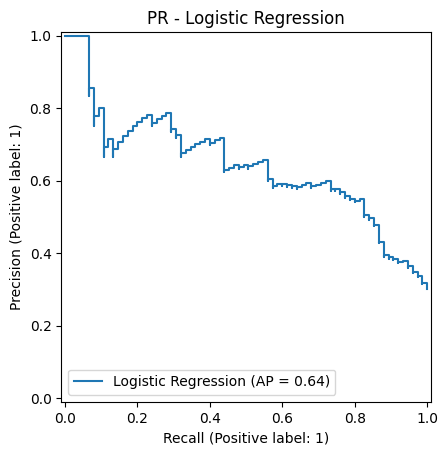


===== Random Forest | Test =====
Accuracy : 0.772
ROC AUC  : 0.807
              precision    recall  f1-score   support

     Good(0)      0.786     0.926     0.850       175
      Bad(1)      0.705     0.413     0.521        75

    accuracy                          0.772       250
   macro avg      0.745     0.670     0.686       250
weighted avg      0.762     0.772     0.752       250

Confusion matrix:
 [[162  13]
 [ 44  31]]


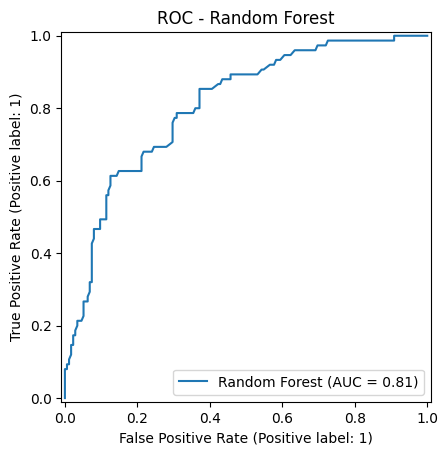

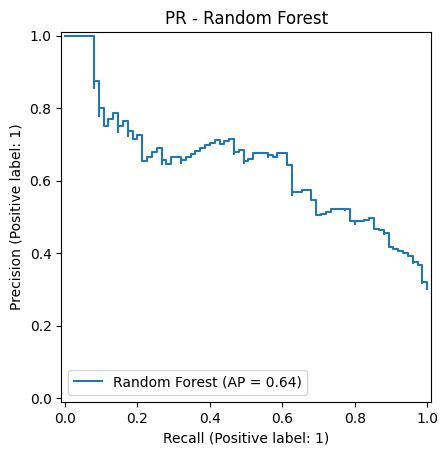


Top coeficientes (absolutos) - Logistic Regression:


,0
Status_checking_A14,-0.517636
Credit_amount,0.393263
Installment_rate,0.375443
Credit_history_A34,-0.347947
Purpose_A41,-0.333289
Foreign_worker_A202,-0.317805
Duration,0.283626
Status_checking_A11,0.282245
Savings_A65,-0.278392
Property_A124,0.272121



Top importancias - Random Forest:


,0
Credit_amount,0.092852
Duration,0.076414
Age,0.071088
Status_checking_A14,0.065262
Installment_rate,0.035096
Status_checking_A11,0.034370
Residence_since,0.031582
Credit_history_A34,0.025828
Savings_A61,0.024624
Status_checking_A12,0.020160


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# ========= 0) Preparar X, y (robusto) =========
import numpy as np
import pandas as pd

SEED = 42

def detect_target_col(df, candidates=("Credit risk","credit risk","Credit_risk","credit_risk","class","target")):
    # busca nombres equivalentes
    norm = {c: c.strip().lower().replace(" ", "").replace("-", "_") for c in df.columns}
    want = {s.replace(" ", "").replace("-", "_") for s in map(str.lower, candidates)}
    for orig, n in norm.items():
        if n in want:
            return orig
    return None

def map_target_to_01(y_raw: pd.Series) -> pd.Series:
    vals = pd.unique(y_raw)
    # UCI: 1=Good, 2=Bad
    if set(vals).issubset({1,2}):
        return (y_raw.astype(int) == 2).astype(int)
    # binario 0/1 ya listo
    if set(vals).issubset({0,1}):
        return y_raw.astype(int)
    # etiquetas de texto
    y = y_raw.astype(str).str.lower().map({"good":0, "bad":1})
    if y.isna().any():
        raise ValueError(f"No pude mapear los valores del objetivo a 0/1. Vistos: {vals[:8]}")
    return y

# 1) si df_ohe YA trae la etiqueta:
if detect_target_col(df_ohe) is not None:
    tgt_col = detect_target_col(df_ohe)
    df = df_ohe.copy()
    y = map_target_to_01(df[tgt_col])
    X = df.drop(columns=[tgt_col])

# 2) si df_ohe NO trae etiqueta, la tomamos del DF original crudo (debe existir en el entorno):
else:
    # intenta encontrar el DF crudo que conserva 'Credit risk'
    df_raw = None
    for name in ("df_original","df_raw","df","raw","df_german"):
        if name in globals() and isinstance(globals()[name], pd.DataFrame):
            df_raw = globals()[name]
            break
    if df_raw is None:
        raise RuntimeError(
            "df_ohe no tiene columna objetivo y no encontré un DF crudo (df_original/df_raw/df/...) con 'Credit risk'."
        )
    tgt_col = detect_target_col(df_raw)
    if tgt_col is None:
        raise KeyError(f"No encuentro columna objetivo en DF crudo. Columnas: {list(df_raw.columns)[:20]} ...")

    # alineamos por índice
    y = map_target_to_01(df_raw.loc[df_ohe.index, tgt_col])
    X = df_ohe.copy()

print("Objetivo:", tgt_col, "| y distribution:", y.value_counts(normalize=True)
      .rename({0:'Good',1:'Bad'}).round(3).to_dict())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=SEED
)


# ========= 1) Definir modelos y pipelines =========
pipe_logit = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False para datos dispersos tras OHE
    ('clf', LogisticRegression(
        max_iter=2000, class_weight='balanced', solver='lbfgs', n_jobs=None, random_state=SEED
    ))
])

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    class_weight='balanced', random_state=SEED, n_jobs=-1
)

# ========= 2) Validación cruzada (train only) =========
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = {'roc_auc':'roc_auc', 'f1':'f1', 'recall':'recall', 'precision':'precision', 'accuracy':'accuracy'}

cv_logit = cross_validate(pipe_logit, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
cv_rf    = cross_validate(rf,         X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

def summarize_cv(name, cvres):
    print(f"\n== {name} | 5-Fold CV ==")
    for k,v in cvres.items():
        if k.startswith('test_'):
            metric = k.replace('test_','').upper()
            print(f"{metric:>8}: {np.mean(v):.3f} ± {np.std(v):.3f}")

summarize_cv("Logistic Regression", cv_logit)
summarize_cv("Random Forest",       cv_rf)

# ========= 3) Entrenamiento final y evaluación en test =========
pipe_logit.fit(X_train, y_train)
rf.fit(X_train, y_train)

def eval_on_test(name, model, X_test, y_test):
    # Probabilidades (o scores) de la clase positiva
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
        # Si decision_function no está en [0,1], ROC-AUC igual funciona; para PR podemos usarlo también.
    else:
        # Fallback a predicción dura (no ideal para ROC/PR)
        y_prob = model.predict(X_test)

    # Umbral 0.5 para la predicción binaria (ajústalo según negocio si quieres)
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== {name} | Test =====")
    print("Accuracy :", round(acc, 3))
    print("ROC AUC  :", round(auc, 3))
    print(classification_report(y_test, y_pred, target_names=['Good(0)','Bad(1)'], digits=3))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)

    # Curvas
    RocCurveDisplay.from_predictions(y_test, y_prob, name=name)
    plt.title(f"ROC - {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_prob, name=name)
    plt.title(f"PR - {name}")
    plt.show()

eval_on_test("Logistic Regression", pipe_logit, X_test, y_test)
eval_on_test("Random Forest",       rf,        X_test, y_test)

# ========= 4) Interpretabilidad =========
# 4a) Coeficientes de la logística
logit_clf = pipe_logit.named_steps['clf']
# Nota: StandardScaler(with_mean=False) no altera orden de columnas
coef = pd.Series(logit_clf.coef_.ravel(), index=X_train.columns).sort_values(key=abs, ascending=False)
print("\nTop coeficientes (absolutos) - Logistic Regression:")
display(coef.head(15))

# 4b) Importancia en Random Forest
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop importancias - Random Forest:")
display(imp.head(15))

### 3.5 Descripción de resultados obtenidos

- **Logistic Regression**  
  - AUC ≈ 0.80  
  - Mejor *recall* en clientes "malos" (80%), útil para reducir riesgo crediticio.  
  - Variables clave: `Status of checking account`, `Credit amount`, `Installment rate`.

- **Random Forest**  
  - AUC ≈ 0.81, ligera mejora sobre LogReg.  
  - Mejor *precisión* en clientes "buenos" (92%).  
  - Variables clave: `Credit amount`, `Duration in month`, `Age`.

En general, ambos modelos discriminan bien entre clientes buenos y malos.  
LogReg es más interpretable, RF más robusto.

### 3.6 Medición del rendimiento de los modelos

- **Curvas ROC y PR**: ambos modelos superan el azar significativamente.  
- **Métricas CV (5-Fold)**: RF con mayor precisión media, LogReg con mejor recall.  
- **Conclusión parcial**: la elección depende del objetivo del banco:  
  - **Maximizar recall (detectar más riesgos)** → Regresión Logística.  
  - **Maximizar precisión y robustez general** → Random Forest.



# 4. Conclusiones

## 4.1 ¿Qué variables proporcionan mayor información?

El análisis conjunto entre los modelos no supervisados (tablas reducidas y métricas de lift) y los supervisados (importancias de Random Forest y coeficientes de Regresión Logística) mostró coincidencias claras.  
Las variables que más información aportan son:

- **Credit amount**: con alta importancia en Random Forest y coeficiente significativo en LogReg (a mayor monto, mayor probabilidad de incumplimiento).  
- **Duration in month**: presente en ambos modelos y clave para separar plazos cortos de plazos largos.  
- **Age in years**: relevante en Random Forest y diferenciador en los clusters (jóvenes vs. mayores).  
- **Status of existing checking account** (A14, A11): con gran peso en ambos modelos, relacionado con la liquidez del solicitante.  
- **Installment rate (% ingreso disponible)**: fuerte en LogReg, indicador de presión financiera.  
- **Credit history** (A34): resume el comportamiento crediticio previo.  

Otras variables como **residencia actual, ahorros, número de créditos existentes, propiedad, vivienda y empleo** también mostraron relevancia secundaria.  
En cuanto a dimensionalidad, los análisis PCA (2D y 3D) permitieron visualizar mejor los clusters, aunque explican poca varianza (~0.116 y ~0.162). La señal principal se conserva en el espacio completo (20D).

---

## 4.2 ¿Qué modelo tuvo el mejor desempeño y por qué?

En pruebas de validación y test:

- **Random Forest**: Accuracy ≈ 0.76, ROC AUC ≈ 0.81. Destacó por su mayor precisión al identificar buenos clientes, aunque con menor recall en la clase de incumplimiento.  
- **Logistic Regression**: Accuracy ≈ 0.74, ROC AUC ≈ 0.80. Mostró mejor recall para clientes incumplidos (≈ 0.80), además de ser más interpretable.

En conclusión, **Random Forest** logró un mejor desempeño global (mayor AUC y estabilidad), mientras que **Logistic Regression** resultó preferible cuando el objetivo es detectar con mayor sensibilidad a los clientes de alto riesgo.  
La decisión final depende del costo relativo de los falsos positivos y falsos negativos: para minimizar riesgo crediticio es preferible LogReg, mientras que para clasificación global y ranking de riesgo, Random Forest ofrece más robustez.

---

## 4.3 ¿Qué variables se proponen para mejorar el cálculo del otorgamiento de crédito?

Para enriquecer el modelo y alinear con prácticas reales de crédito, se sugieren variables adicionales:

- **Ingresos, egresos y deuda total** (salario comprobable, gastos fijos, otras deudas).  
- **Ratios financieros** como DTI (deuda/ingreso) y PTI (pago/ingreso del préstamo).  
- **Historial externo de buró de crédito**: score, moras, antigüedad crediticia, utilización de líneas.  
- **Características laborales**: tipo de contrato, antigüedad en el empleo, sector.  
- **Activos y colateral** (valor, relación préstamo/garantía).  
- **Comportamiento transaccional**: historial de pagos de servicios, movimientos bancarios.  
- **Variables de canal y producto**: propósito del crédito, monto/ingreso solicitado, solicitudes recientes.  
- **Contexto geográfico y macroeconómico**: indicadores locales de desempleo o riesgo.

Estas variables aumentarían el poder predictivo y mejorarían la calibración de los modelos.

---

# 5. Referencias

## 5.1 Citas en formato APA

- Breiman, L. (2001). Random Forests. *Machine Learning*, 45, 5–32.  
- Hosmer, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). *Applied Logistic Regression* (3rd ed.). Wiley.  
- Calinski, T., & Harabasz, J. (1974). A dendrite method for cluster analysis. *Communications in Statistics*, 3(1), 1–27.  
- Rousseeuw, P. J. (1987). Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. *Journal of Computational and Applied Mathematics*, 20, 53–65.  
- Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. *JMLR*, 12, 2825–2830.  
- UCI Machine Learning Repository. (German Credit). University of California, Irvine.  
- Comisión Nacional para la Protección y Defensa de los Usuarios de Servicios Financieros (CONDUSEF). Guías sobre crédito al consumo.  
- Comisión Nacional Bancaria y de Valores (CNBV). Disposiciones en materia de crédito y gestión de riesgos.

---

## 5.2 Fuentes consultadas para entender el problema

- Documentación del dataset German Credit (UCI).  
- Material de la CONDUSEF sobre otorgamiento de crédito al consumo.  
- Regulaciones de la CNBV sobre riesgo de crédito.

---

## 5.3 Fuentes consultadas para ampliar el conocimiento en modelos de aprendizaje

- Documentación oficial de *Scikit-learn* (clasificación, métricas, calibración).  
- Referencias académicas sobre Regresión Logística y Random Forest.  
- Artículos sobre validación interna de clustering (Silhouette y Calinski-Harabasz).  
- Notas teóricas sobre PCA y reducción de dimensionalidad.